In [ ]:
!pip install transformers 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 10.8 MB/s eta 0:00:00


In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "" # Enter your kaggle user name
os.environ['KAGGLE_KEY'] = "" # Enter your kaggle key here

In [ ]:
!kaggle datasets download -d adityajn105/flickr8k

100% 1.03G/1.04G [00:30<00:00, 38.8MB/s]
100% 1.04G/1.04G [00:30<00:00, 36.7MB/s]


In [ ]:
!unzip -q flickr8k.zip 

In [ ]:
print(len(os.listdir("Images")))

8091


In [ ]:
!kaggle datasets download -d begum302553/tasviret-flickr8k-turkish

100% 946k/946k [00:00<00:00, 1.88MB/s]
100% 946k/946k [00:00<00:00, 1.87MB/s]


In [ ]:
!unzip -q tasviret-flickr8k-turkish.zip 

In [ ]:
from __future__ import print_function, division
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import torch.nn.functional as F
from tqdm import tqdm
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.utils as vutils
from torchvision.transforms.functional import (
    hflip,
    adjust_brightness,
    adjust_contrast,
    adjust_hue,
    adjust_saturation,
)
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from datetime import datetime
from torchvision import models

In [ ]:
"""
https://stackoverflow.com/questions/62523912/how-to-freeze-selected-layers-of-a-model-in-pytorch

https://huggingface.co/docs/transformers/model_doc/distilbert

https://www.kaggle.com/datasets/begum302553/tasviret-flickr8k-turkish

https://huggingface.co/dbmdz/distilbert-base-turkish-cased

https://github.com/stefan-it/turkish-bert

https://keras.io/examples/vision/nl_image_search/

newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))

"""

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("dbmdz/distilbert-base-turkish-cased")
model = AutoModel.from_pretrained("dbmdz/distilbert-base-turkish-cased")

inputs = tokenizer("Benim adım kırmızı")
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state

Some weights of the model checkpoint at dbmdz/distilbert-base-turkish-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
last_hidden_states.shape

torch.Size([1, 5, 768])

In [ ]:
inputs

{'input_ids': tensor([[   2, 4207, 3816, 5928,    3]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}

In [ ]:
inputs["input_ids"].shape

torch.Size([1, 5])

In [ ]:
caption_list = ["Merhaba nasılsınız?","Ali topu tut","Ahmet elindeki vazoyu duvara en yakın masanın üzerine bıraktı"]

In [ ]:
print(len(caption_list))
token_list = tokenizer(caption_list,padding = True)
print(len(token_list["input_ids"][0]))

3
12


In [ ]:
type(token_list["input_ids"])

list

In [ ]:
len(token_list["input_ids"][0])

12

In [ ]:
data = pd.read_json("tasviret8k_captions.json")

In [ ]:
data["images"][0]["sentences"][0]["raw"]

'Sarı ve siyah tüylü iki köpek karda koşuyor.'

In [ ]:
caption_list = []



for d in data["images"]:
  sentences = d["sentences"]
  for j in sentences:
    caption_list.append(j["raw"])


In [ ]:
token_list = tokenizer(caption_list,padding = True) #,truncation = True)
print(len(token_list["input_ids"][0]))

35


In [ ]:
data_list = []



for d in data["images"]:
  file_name = d["filename"]
  sentences = d["sentences"]
  sentence_list = []

  for i in sentences:
    sentence_list.append(i["raw"])

  data_list.append([file_name,sentence_list])

In [ ]:
data_list[2]

['3338291921_fe7ae0c8f8.jpg',
 ['Açık kahverengi bir bulldog, karlı bir günde, ağzıyla parlak pembe renkli, kumaşa benzeyen bir cisim taşıyor.',
  'Karlı bir günde pembe bir kumaş parçasını ağzında taşımakta olan bir köpek.']]

In [ ]:
data = pd.read_json("tasviret8k_captions.json")

In [ ]:
data[:7000]

,images,dataset
0,"{'split': 'train', 'filename': '2513260012_03d...",flickr8k
1,"{'split': 'train', 'filename': '2903617548_d3e...",flickr8k
2,"{'split': 'train', 'filename': '3338291921_fe7...",flickr8k
3,"{'split': 'train', 'filename': '488416045_1c6d...",flickr8k
4,"{'split': 'train', 'filename': '2644326817_8f4...",flickr8k
...,...,...
6995,"{'split': 'val', 'filename': '3487378989_c051d...",flickr8k
6996,"{'split': 'val', 'filename': '2189181027_a445b...",flickr8k
6997,"{'split': 'val', 'filename': '2631625732_75b71...",flickr8k
6998,"{'split': 'val', 'filename': '2665586311_9a5f4...",flickr8k


In [ ]:
data[:7000].shape

(7000, 2)

In [ ]:

np.random.seed(2)
torch.manual_seed(2)


class Image_dataset(Dataset):
    def __init__(self, root_dir, data_frame, transform):

        self.root_dir = root_dir
        self.data_frame = data_frame
        self.transform = transform

        self.data_list = []

        for row in self.data_frame["images"]:
          file_name = row["filename"]
          sentences = row["sentences"]
          sentence_list = []

          for i in sentences:
            sentence_list.append(i["raw"])

          self.data_list.append([file_name,sentence_list])

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_name, captions = self.data_list[idx]
        try:
          img = Image.open(os.path.join(self.root_dir,image_name))
        except Exception as e:
          print(e)

        img = self.transform(img)
        
        #load caption randomly

        caption = np.random.choice(captions)

        return img, caption

data = pd.read_json("tasviret8k_captions.json")

train_set = Image_dataset(
    root_dir = "Images",
    data_frame = data[:7000],
    transform=transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
],
    ),
)

val_set = Image_dataset(
    root_dir = "Images",
    data_frame = data[7000:],
    transform=transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
],
    ),
)


def customBatchBuilder(samples):
    img, caption = zip(*samples)

    token_list = tokenizer(caption,padding = True)
    img = torch.stack(img)

    text = torch.Tensor(token_list["input_ids"]).long()
    mask = torch.Tensor(token_list["attention_mask"]).long()

    return img, text, mask


train_set_size = len(train_set)
print("Train set size:", train_set_size)
val_set_size = len(val_set)



batch_size = 64

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=customBatchBuilder)

val_loader = DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=customBatchBuilder)



print("Train set size:", train_set_size)
print("Val set size:", val_set_size)


image_datasets = {"train": train_set, "val": val_set}

dataloaders = {"train": train_loader, "val": val_loader}

dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}

print(dataset_sizes)

inputs, text , mask = next(iter(dataloaders["train"]))

print("Sample input shape ", inputs.shape)
print("Sample text shape", text.shape)

device = torch.device(
    "cuda:0" if torch.cuda.is_available() else "cpu"
)  # checks if there is gpu available


Train set size: 7000
Train set size: 7000
Val set size: 1000
{'train': 7000, 'val': 1000}
Sample input shape  torch.Size([64, 3, 224, 224])


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.image_encoder = models.resnet18(weights = "ResNet18_Weights.DEFAULT")
        self.image_encoder.fc = nn.Identity()
        
        self.image_out = nn.Sequential(
            nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 256)
        )

        self.text_encoder = AutoModel.from_pretrained("dbmdz/distilbert-base-turkish-cased")
        self.target_token_idx = 0


        self.text_out = nn.Sequential(
            nn.Linear(768, 256), nn.ReLU(), nn.Linear(256, 256)
        )
      

    def forward(self, image, text, mask):

        image_vec = self.image_encoder(image)
        #print("resnet out",image_vec.shape)
        image_vec = self.image_out(image_vec.view(-1,512))
        #print("image vec",image_vec.shape)
        #print("text",text.shape)
        #print("mask",mask.shape)
        text_out = self.text_encoder(text, mask)
        last_hidden_states = text_out.last_hidden_state
        #print("last_hidden_states 1",last_hidden_states.shape)
        last_hidden_states = last_hidden_states[:,self.target_token_idx,:]
        #print("last_hidden_states 2",last_hidden_states.shape)
        text_vec = self.text_out(last_hidden_states.view(-1,768))


        return image_vec, text_vec

inputs, text , mask = next(iter(dataloaders["train"]))

model = Net()
img_vec, text_vec = model(inputs, text,mask)
print(img_vec.shape)
print(text_vec.shape)

criterion = nn.CrossEntropyLoss() 

image_similarity = torch.matmul(img_vec, img_vec.T)

text_similarity = torch.matmul(text_vec, text_vec.T)

logits = torch.matmul(img_vec, text_vec.T)

print(image_similarity.shape)
print(text_similarity.shape)
print(logits.shape)

targets = torch.arange(logits.size(0)).long()

texts_loss = criterion(logits, targets)
images_loss = criterion(logits.T, targets)
loss = (images_loss + texts_loss) / 2.0  
print(images_loss)
print(texts_loss)

Some weights of the model checkpoint at dbmdz/distilbert-base-turkish-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([64, 256])
torch.Size([64, 256])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
tensor(4.2502, grad_fn=<NllLossBackward0>)
tensor(4.1626, grad_fn=<NllLossBackward0>)


In [ ]:
log = False

In [ ]:


def train_model(
    model, criterion, optimizer, num_epochs=25, checkp_epoch=0, scheduler=None
):
    since = time.time()

    if log == True:
        my_file = open(plot_file, "a")

    pbar = tqdm(range(checkp_epoch, num_epochs))
    for epoch in pbar:  # range(checkp_epoch,num_epochs):
        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 10)

        # Each epoch has a training and validation phase
        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        # pbar=tqdm(train_loader)
        for sample in train_loader:
            input, texts,masks = sample
            batch_size = input.size(0)
            input = input.to(device)  # .reshape(-1, input.size(0), 60*41)
            texts = texts.to(device)
            masks = masks.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):

                image_vec, text_vec = model(
                    input, texts , masks
                )  # .view((batch_size,-1,60,41)))

                logits = torch.matmul(text_vec, image_vec.T)
                images_similarity = torch.matmul(image_vec, image_vec.T)
                texts_similarity = torch.matmul(text_vec, text_vec.T)
                
                targets = torch.arange(logits.size(0)).long().to(device)

                texts_loss = criterion(logits, targets)
                images_loss = criterion(logits.T, targets)
                loss = (images_loss + texts_loss) / 2.0  # shape: (batch_size)

                loss.backward()
                optimizer.step()
                if scheduler != None:
                    scheduler.step()
            # statistics

            running_loss += loss.item() * input.size(0)

        train_loss = running_loss / train_set_size

        # print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        #    phase, epoch_loss, epoch_acc))
        model.eval()  # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for sample in val_loader:
                input, texts,masks = sample

                input = input.to(
                    device
                )  # .reshape(-1, input.size(0), 60*41).to(device)
                texts = texts.to(device)
                masks = masks.to(device)

                image_vec, text_vec = model(
                    input, texts , masks
                )  # .view((batch_size,-1,60,41)))


                # forward
                # track history if only in train
                with torch.set_grad_enabled(False):
                  logits = torch.matmul(text_vec, image_vec.T)
                  images_similarity = torch.matmul(image_vec, image_vec.T)
                  texts_similarity = torch.matmul(text_vec, text_vec.T)

                  targets = torch.arange(logits.size(0)).long().to(device)

                  texts_loss = criterion(logits, targets)
                  images_loss = criterion(logits.T, targets)
                  loss = (images_loss + texts_loss) / 2.0  # shape: (batch_size)

                # statistics
                running_loss += loss.item() * inputs.size(0)

        val_loss = running_loss / val_set_size
        if log == "True":
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "loss": loss,
                },
                checkpoint_file,
            )

            data = {
                "epoch": epoch,
                "train_loss": train_loss,
                "val_loss": val_loss,
            }
            df = pd.DataFrame(data, index=[0])  # index=[0] denmezse hata veriyor
            df.to_csv(my_file, header=False, index=False)
        # print()

        pbar.set_description(
            "train loss {:.4} val loss {:.4}".format(train_loss, val_loss)
        )
    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )

    # load best model weights

    return model


model_ft = Net().to(device)

criterion = nn.CrossEntropyLoss()  # nn.MultiMarginLoss()

# Observe that all parameters are being optimized

optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-4)  # , weight_decay=1e-4)

now = datetime.now()

checkpoint_file = "turkish_clip" + now.strftime("%d_%m_%Y_%H:%M:%S") + ".pt"
plot_file = "turkish_clip" + now.strftime("%d_%m_%Y_%H:%M:%S") + ".csv"


num_epochs = 3


model_ft = train_model(
    model_ft, criterion, optimizer_ft, num_epochs=num_epochs, scheduler=None
)


Some weights of the model checkpoint at dbmdz/distilbert-base-turkish-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
train loss 1.44 val loss 2.014: 100%|██████████| 3/3 [04:48<00:00, 96.22s/it]

Training complete in 4m 49s


In [ ]:
torch.save(model_ft.state_dict(),"clip_model.pt")

In [ ]:
soft = nn.Softmax(dim=1)
transform=transforms.Compose(
        [
            transforms.Resize((224, 224)),
            # transforms.Grayscale(1),
            # transforms.RandomHorizontalFlip(p=1),
            # transforms.RandomRotation(degrees = 15),
            # transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
            transforms.ToTensor(),
            # transforms.Normalize([0.5], [0.5])]
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
],
)

In [ ]:
id = 700
file_name = data[7000:]["images"].values[id]["filename"]
print(data[7000:]["images"].values[id]["filename"])
print(data[7000:]["images"].values[id]["sentences"])

2373234213_4ebe9c4ee5.jpg
[{'sentid': 15435, 'imgid': 7700, 'raw': 'Trambolinde oynayan iki çocuk.', 'tokens': ['Trambolinde', 'oynayan', 'iki', 'çocuk']}, {'sentid': 15436, 'imgid': 7700, 'raw': 'Trambolin üzerinde arkadaşının üzerinden havaya doğru zıplayan bir erkek çocuğu.', 'tokens': ['Trambolin', 'üzerinde', 'arkadaşının', 'üzerinden', 'havaya', 'doğru', 'zıplayan', 'bir', 'erkek', 'çocuğu']}]


In [ ]:
img = Image.open("./Images/{}".format(file_name))

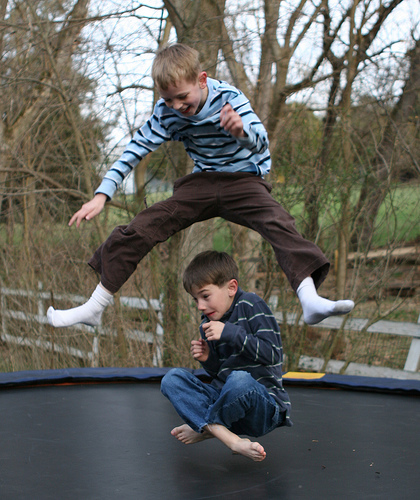

In [ ]:
img

In [ ]:
model_ft.to("cpu")
input = transform(img).unsqueeze(0)

text_vec = ["Zıplayan iki çocuk.","Zıplayan iki kız."]
token_list = tokenizer(text_vec,padding = True)

text = torch.Tensor(token_list["input_ids"]).long()
mask = torch.Tensor(token_list["attention_mask"]).long()


image_vec, text_vec = model_ft(input, text , mask) 
print(soft(torch.matmul(image_vec,text_vec.T)))

tensor([[0.6960, 0.3040]], grad_fn=<SoftmaxBackward0>)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
